# CoViD 19 - Data Viz Lombardia

In [8]:
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import statsmodels.api as sm
plt.style.use('seaborn-white')

print("pandas v: {}".format(pd.__version__))

pandas v: 0.25.1


In [9]:
plt.rcParams['axes.titlesize']=20
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16

# colors
col_green = "#{:02x}{:02x}{:02x}".format(0,158,115)
col_yellow = "#{:02x}{:02x}{:02x}".format(240, 228, 66)
col_blue = "#{:02x}{:02x}{:02x}".format(0, 114, 178)

Read data

In [10]:
file_input = []
for f in os.listdir('COVID-19/dati-regioni/'):
    if re.match('dpc-covid19-ita-regioni-2020',f):
        file_input.append(f)


In [11]:
df = pd.read_csv(os.path.join('COVID-19/dati-regioni',file_input[0]))
for i in range(1,len(file_input)):
    df = pd.concat([df, pd.read_csv(os.path.join('COVID-19','dati-regioni',file_input[i]))])

In [12]:
df['data'] = df.data.apply(lambda x : x[:10])
df['data'] = pd.to_datetime(df.data)
df = df.sort_values('data')
df['wday'] = df.data.dt.weekday
df.loc[:,'week'] = df.data.dt.week

In [13]:
df_lom = df[df.denominazione_regione.isin(['Lombardia'])].reset_index(drop=True)

Quick overview of Regioni dataset:

In [14]:
print(df.shape)
df.tail(6)

(903, 21)


,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,...,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en,wday,week
3,2020-04-06,ITA,18,Calabria,38.905976,16.594402,170,14,184,538,...,16,22,37,58,817,13633,NaN,NaN,0,15
2,2020-04-06,ITA,4,P.A. Bolzano,46.499335,11.356624,245,52,297,963,...,34,78,298,164,1722,16825,NaN,NaN,0,15
1,2020-04-06,ITA,17,Basilicata,40.639471,15.805148,46,18,64,198,...,8,9,12,13,287,3061,NaN,NaN,0,15
20,2020-04-06,ITA,5,Veneto,45.434905,12.338452,1714,322,2036,7686,...,313,362,1204,662,11588,146288,NaN,NaN,0,15
9,2020-04-06,ITA,3,Lombardia,45.466794,9.190347,11914,1343,13257,15212,...,345,1079,13863,9202,51534,154989,NaN,NaN,0,15
19,2020-04-06,ITA,2,Valle d'Aosta,45.737503,7.320149,109,21,130,437,...,-9,23,142,96,805,2590,NaN,NaN,0,15


## Plots

### (1) - Nuovi casi di contagi giornalieri in Lombardia.

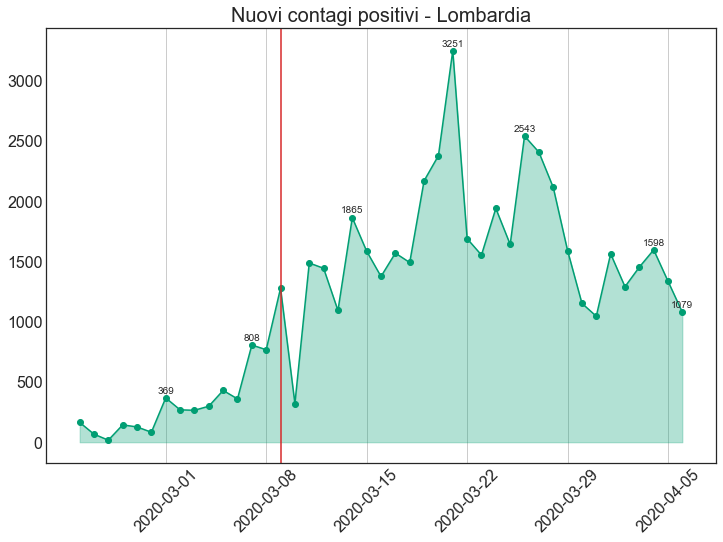

In [16]:
plt.rcParams['figure.figsize'] = 12, 8
plt.rc('axes', axisbelow=True)
gdf = df_lom.groupby(['week']).agg({'nuovi_positivi':[pd.Series.argmax, max]}).reset_index()


plt.plot(df_lom.data, df_lom.nuovi_positivi,color=col_green)
plt.scatter(df_lom.data, df_lom.nuovi_positivi, color=col_green)
plt.gca().xaxis.grid(color='gray',alpha=0.5)
plt.fill_between(x=df_lom.data, y1=df_lom.nuovi_positivi,color=col_green,alpha=0.3)

plt.gca().set_axisbelow(True)
  
for l in range(len(df_lom.nuovi_positivi)):
    if (l in gdf['nuovi_positivi']['idxmax'].values.tolist() or l == len(df_lom)-1):
        plt.text(x=df_lom.data.values[l],
                 y=df_lom.nuovi_positivi.values[l] +20,
                 s=round(df_lom.nuovi_positivi.values[l],1),
                 size=10,horizontalalignment='center',
                 verticalalignment='bottom'#,alpha=0.8
                )
_ = plt.title('Nuovi contagi positivi - Lombardia')
_=plt.xticks(df_lom[df_lom.wday.isin([6])].data.values,rotation = 45)
_=plt.axvline(pd.to_datetime('2020-03-09'),
            color='tab:red')

### (2) Nuovi contagi confrontati con il resto d'Italia

In [17]:
gdf = df.groupby(['data']).agg({'nuovi_positivi':'sum'}).reset_index().rename(columns={'nuovi_positivi':'nuovi_positivi_ita'})
df_lom = pd.merge(df_lom, gdf, on=['data'])
df_lom['perc_nuovi_positivi'] = df_lom.nuovi_positivi / df_lom.nuovi_positivi_ita
df_lom['nuovi_positivi_resto'] = df_lom.nuovi_positivi_ita - df_lom.nuovi_positivi

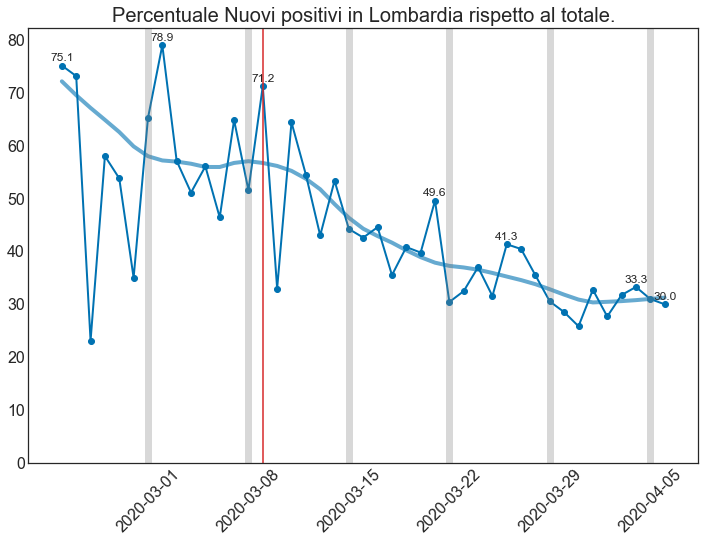

In [18]:
plt.rcParams['figure.figsize'] = 12, 8

smooth = sm.nonparametric.lowess(exog=list(np.arange(len(df_lom))), endog=df_lom.perc_nuovi_positivi.values,frac=0.3)[:,1]
gdf = df_lom.groupby(['week']).agg({'perc_nuovi_positivi':[pd.Series.argmax, max]}).reset_index()
col = '#{:02x}{:02x}{:02x}'.format( 0, 113 , 188 )

plt.plot(df_lom.data, df_lom.perc_nuovi_positivi*100,color=col_blue,linewidth=2)
plt.scatter(df_lom.data, df_lom.perc_nuovi_positivi*100,color=col_blue,linewidth=1)
plt.plot(df_lom.data, smooth*100,color=col_blue,alpha=0.6,linewidth=4)
_ = plt.xticks(df_lom[df_lom.wday.isin([6])].data.values,rotation = 45)
_=plt.ylim(0)
for b in df_lom[df_lom.wday.isin([6])].data.values:
    plt.axvline(b,color='gray',linewidth=7,alpha=0.3)
plt.axvline(pd.to_datetime('2020-03-09'),
            color='tab:red')
    
for l in range(len(df_lom.perc_nuovi_positivi)):
    if (l in gdf['perc_nuovi_positivi']['idxmax'].values.tolist() or l == len(df_lom)-1):
        plt.text(x=df_lom.data.values[l],
                 y=df_lom.perc_nuovi_positivi.values[l]*100 +0.5,
                 s=round(df_lom.perc_nuovi_positivi.values[l]*100,1),
                 size=7.5,horizontalalignment='center',
                 verticalalignment='bottom',fontsize=12
                )

_ = plt.title('Percentuale Nuovi positivi in Lombardia rispetto al totale.',size=20)

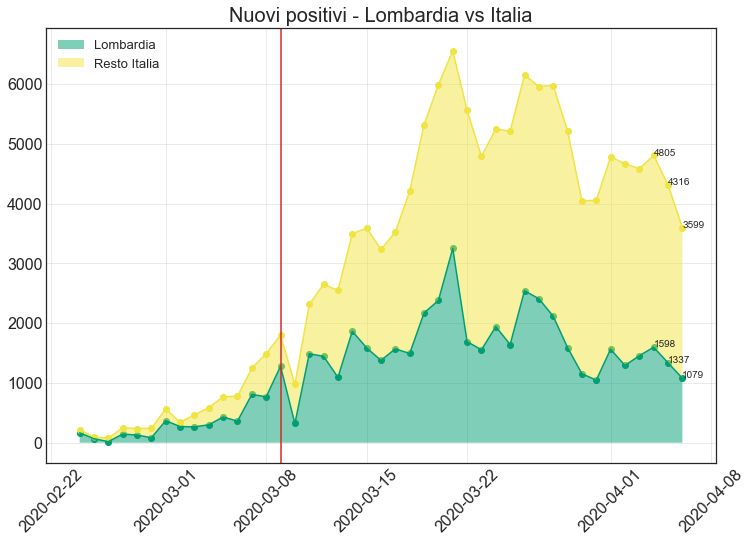

In [28]:
plt.rcParams['figure.figsize'] = 12, 8
plt.plot(df_lom.data, df_lom.nuovi_positivi,color=col_green)
plt.scatter(df_lom.data, df_lom.nuovi_positivi,color=col_green)
plt.plot(df_lom.data, df_lom.nuovi_positivi_ita, color=col_yellow)
plt.scatter(df_lom.data, df_lom.nuovi_positivi_ita, color=col_yellow)
plt.stackplot(df_lom.data, [df_lom.nuovi_positivi,df_lom.nuovi_positivi_resto],
              colors=[col_green,col_yellow],alpha=0.5,
              labels=['Lombardia','Resto Italia'])
plt.legend(loc='upper left',fontsize=13)
plt.grid(alpha=0.5)
plt.gca().set_axisbelow(True)
plt.axvline(pd.to_datetime('2020-03-09'),
            color='tab:red')
plt.title('Nuovi positivi - Lombardia vs Italia',size=20)
_=plt.xticks(rotation=45)
_=plt.yticks(rotation=0)
for i in range(1,4):
    plt.text(x=df_lom.data[len(df_lom)-i],y=df_lom.nuovi_positivi[len(df_lom)-i],s=df_lom.nuovi_positivi[len(df_lom)-i])
    plt.text(x=df_lom.data[len(df_lom)-i],y=df_lom.nuovi_positivi_ita[len(df_lom)-i],s=df_lom.nuovi_positivi_ita[len(df_lom)-i])

In [20]:
i = len(df_lom)-1
print("Change Percentage Lombardia: {}".format(np.round(df_lom.nuovi_positivi.pct_change()[i],2)))
print("Change Percentage Italia: {}".format(np.round(df_lom.nuovi_positivi_ita.pct_change()[i],2)))

Change Percentage Lombardia: -0.19
Change Percentage Italia: -0.17


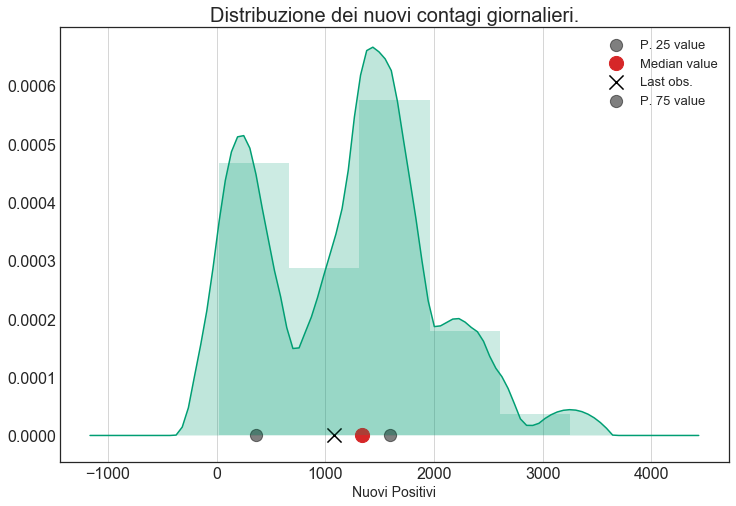

In [21]:
import seaborn as sns
plt.grid(axis='x')
sns.distplot(df_lom.nuovi_positivi,hist=True,color=col_green,
             kde_kws = {'shade': True,'kernel':'epa'},norm_hist=False,hist_kws={'alpha':0.2})
plt.axvline(np.median(df_lom.nuovi_positivi),ymax=0,linewidth=20,color='tab:red')
plt.scatter(np.quantile(df_lom.nuovi_positivi,0.25),0,150,label='P. 25 value',color='black',alpha=0.5)
plt.scatter(np.median(df_lom.nuovi_positivi),0,200,color='tab:red',label='Median value')
plt.scatter(df_lom.nuovi_positivi[len(df_lom)-1],0,200,color='black',marker='x',label='Last obs.')
plt.scatter(np.quantile(df_lom.nuovi_positivi,0.75),0,150,label='P. 75 value',color='black',alpha=0.5)
_=plt.xlabel('Nuovi Positivi')
_=plt.legend(loc='upper right',fontsize=13)
_=plt.title("Distribuzione dei nuovi contagi giornalieri.")

In [22]:
from scipy import stats
pctl_last_obs = np.round(stats.percentileofscore(df_lom.nuovi_positivi,df_lom.nuovi_positivi[i]),2)
print("L'ultima osservazione si trova al {}-mo percentile.".format(pctl_last_obs))

L'ultima osservazione si trova al 39.53-mo percentile.


### (3) Percentage change plot

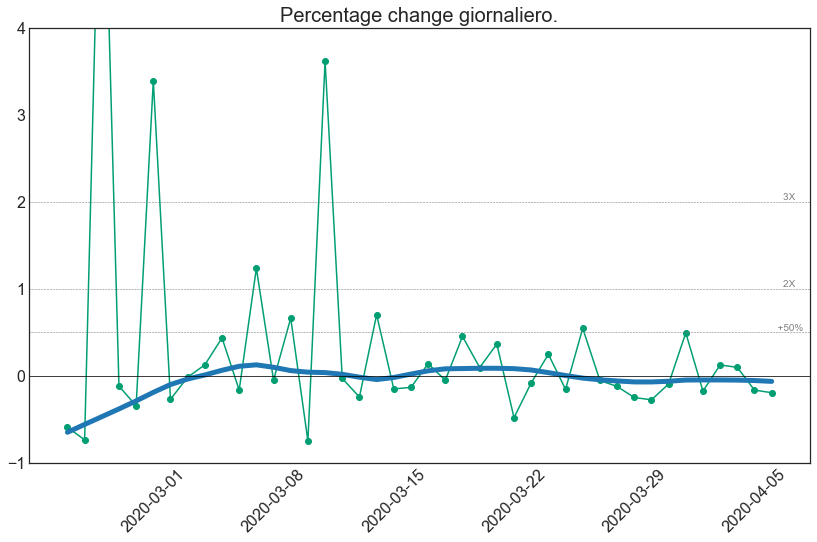

In [23]:
plt.rcParams['figure.figsize'] = 14, 8
smooth = sm.nonparametric.lowess(exog=list(np.arange(len(df_lom))), endog=df_lom.nuovi_positivi.pct_change(periods=1),frac=0.3)[:,1]

plt.plot(df_lom.data,df_lom.nuovi_positivi.pct_change(periods=1),color=col_green)
plt.scatter(df_lom.data,df_lom.nuovi_positivi.pct_change(periods=1),color=col_green)
plt.plot(df_lom.data[1:],smooth,linewidth=5)
_=plt.xticks(df_lom[df_lom.wday.isin([6])].data.values,rotation=45)
plt.ylim(-1,4)
_=plt.axhline(0,color='black',linestyle='-',linewidth=0.75)
_=plt.axhline(0.5,color='gray',linestyle='--',linewidth=0.55)
_=plt.axhline(1,color='gray',linestyle='--',linewidth=0.55)
_=plt.axhline(2,color='gray',linestyle='--',linewidth=0.55)
_=plt.text(x=df_lom.data[i],y=0.52,s="  +50%",color='gray')
_=plt.text(x=df_lom.data[i],y=1.02,s="    2X",color='gray')
_=plt.text(x=df_lom.data[i],y=2.02,s="    3X",color='gray')
_=plt.title("Percentage change giornaliero.")



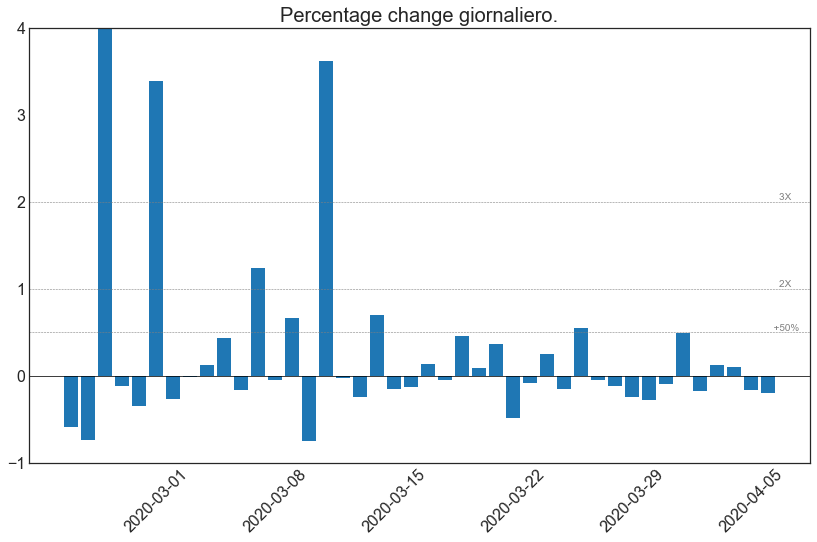

In [24]:
plt.rcParams['figure.figsize'] = 14, 8
plt.bar(
    x=df_lom.data,
    height=df_lom.nuovi_positivi.pct_change(periods=1)
)
_=plt.xticks(df_lom[df_lom.wday.isin([6])].data.values,rotation=45)
plt.ylim(-1,4)
_=plt.axhline(0,color='black',linestyle='-',linewidth=0.75)
_=plt.axhline(0.5,color='gray',linestyle='--',linewidth=0.55)
_=plt.axhline(1,color='gray',linestyle='--',linewidth=0.55)
_=plt.axhline(2,color='gray',linestyle='--',linewidth=0.55)
_=plt.text(x=df_lom.data[i],y=0.52,s="  +50%",color='gray')
_=plt.text(x=df_lom.data[i],y=1.02,s="    2X",color='gray')
_=plt.text(x=df_lom.data[i],y=2.02,s="    3X",color='gray')
_=plt.title("Percentage change giornaliero.")



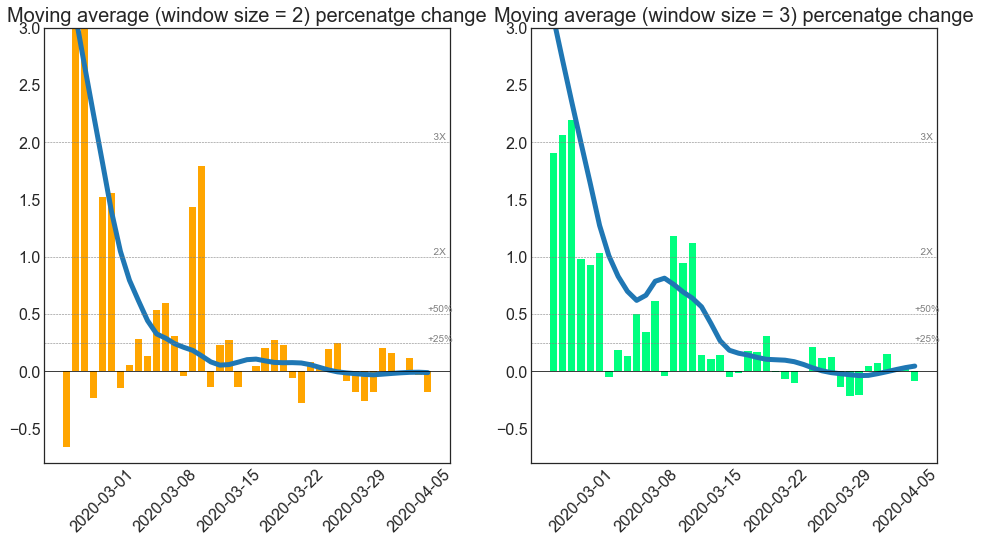

In [25]:
plt.rcParams['figure.figsize'] = 16, 8

smooth = sm.nonparametric.lowess(exog=list(np.arange(len(df_lom))),
                                 endog=df_lom.nuovi_positivi.pct_change(1).rolling(2).sum()/2,
                                 frac=0.3)[:,1]
plt.subplot(121)
plt.bar(
    x=df_lom.data,
    height=df_lom.nuovi_positivi.pct_change(1).rolling(2).sum()/2,
    color='orange'
)
plt.plot(df_lom.data[2:],smooth,linewidth=5)
_=plt.xticks(df_lom[df_lom.wday.isin([6])].data.values,rotation=45)
plt.ylim(-0.8,3)
_=plt.axhline(0,color='black',linestyle='-',linewidth=0.75)
_=plt.axhline(0.25,color='gray',linestyle='--',linewidth=0.55)
_=plt.axhline(0.5,color='gray',linestyle='--',linewidth=0.55)
_=plt.axhline(1,color='gray',linestyle='--',linewidth=0.55)
_=plt.axhline(2,color='gray',linestyle='--',linewidth=0.55)
_=plt.text(x=df_lom.data[i],y=0.26,s="+25%",color='gray')
_=plt.text(x=df_lom.data[i],y=0.52,s="+50%",color='gray')
_=plt.text(x=df_lom.data[i],y=1.02,s="  2X",color='gray')
_=plt.text(x=df_lom.data[i],y=2.02,s="  3X",color='gray')
_=plt.title('Moving average (window size = 2) percenatge change')

plt.subplot(122)
smooth = sm.nonparametric.lowess(exog=list(np.arange(len(df_lom))),
                                 endog=df_lom.nuovi_positivi.pct_change(1).rolling(3).sum()/2,
                                 frac=0.3)[:,1]
plt.bar(
    x=df_lom.data,
    height=df_lom.nuovi_positivi.pct_change(1).rolling(3).sum()/3,
    color='springgreen'
)
plt.plot(df_lom.data[3:],smooth,linewidth=5)
_=plt.xticks(df_lom[df_lom.wday.isin([6])].data.values,rotation=45)
plt.ylim(-0.8,3)
_=plt.axhline(0,color='black',linestyle='-',linewidth=0.75)
_=plt.axhline(0.25,color='gray',linestyle='--',linewidth=0.55)
_=plt.axhline(0.5,color='gray',linestyle='--',linewidth=0.55)
_=plt.axhline(1,color='gray',linestyle='--',linewidth=0.55)
_=plt.axhline(2,color='gray',linestyle='--',linewidth=0.55)
_=plt.text(x=df_lom.data[i],y=0.26,s="+25%",color='gray')
_=plt.text(x=df_lom.data[i],y=0.52,s="+50%",color='gray')
_=plt.text(x=df_lom.data[i],y=1.02,s="  2X",color='gray')
_=plt.text(x=df_lom.data[i],y=2.02,s="  3X",color='gray')
_=plt.title('Moving average (window size = 3) percenatge change')


In [26]:
gdf = df.groupby(['data','wday']).agg({'nuovi_positivi':sum}).reset_index()

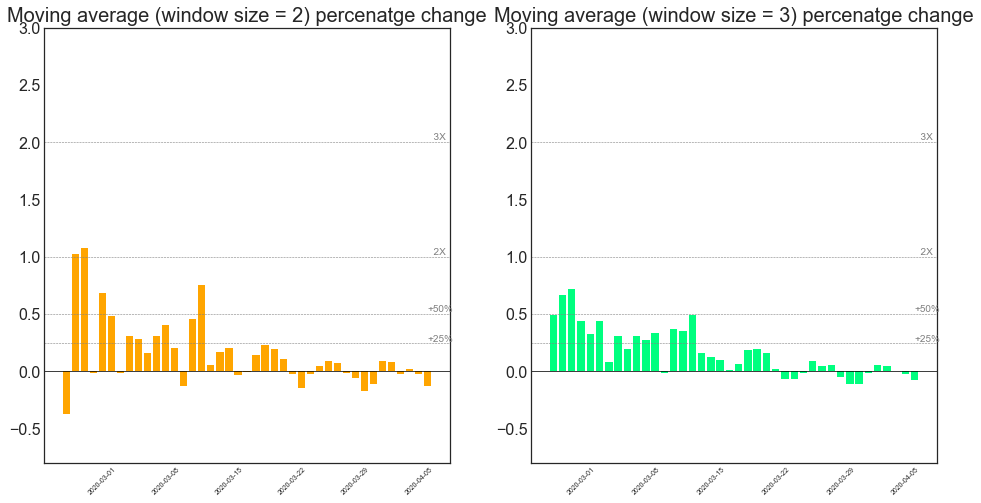

In [27]:
plt.rcParams['figure.figsize'] = 16, 8

plt.subplot(121)
plt.bar(
    x=gdf.data,
    height=gdf.nuovi_positivi.pct_change(1).rolling(2).sum()/2,
    color='orange'
)
_=plt.xticks(gdf[gdf.wday.isin([6])].data.values,rotation=45,size=7)
plt.ylim(-0.8,3)
_=plt.axhline(0,color='black',linestyle='-',linewidth=0.75)
_=plt.axhline(0.25,color='gray',linestyle='--',linewidth=0.55)
_=plt.axhline(0.5,color='gray',linestyle='--',linewidth=0.55)
_=plt.axhline(1,color='gray',linestyle='--',linewidth=0.55)
_=plt.axhline(2,color='gray',linestyle='--',linewidth=0.55)
_=plt.text(x=df_lom.data[i],y=0.26,s="+25%",color='gray')
_=plt.text(x=df_lom.data[i],y=0.52,s="+50%",color='gray')
_=plt.text(x=df_lom.data[i],y=1.02,s="  2X",color='gray')
_=plt.text(x=df_lom.data[i],y=2.02,s="  3X",color='gray')
_=plt.title('Moving average (window size = 2) percenatge change')

plt.subplot(122)
plt.bar(
    x=gdf.data,
    height=gdf.nuovi_positivi.pct_change(1).rolling(3).sum()/3,
    color='springgreen'
)
_=plt.xticks(gdf[gdf.wday.isin([6])].data.values,rotation=45,size=7)
plt.ylim(-0.8,3)
_=plt.axhline(0,color='black',linestyle='-',linewidth=0.75)
_=plt.axhline(0.25,color='gray',linestyle='--',linewidth=0.55)
_=plt.axhline(0.5,color='gray',linestyle='--',linewidth=0.55)
_=plt.axhline(1,color='gray',linestyle='--',linewidth=0.55)
_=plt.axhline(2,color='gray',linestyle='--',linewidth=0.55)
_=plt.text(x=df_lom.data[i],y=0.26,s="+25%",color='gray')
_=plt.text(x=df_lom.data[i],y=0.52,s="+50%",color='gray')
_=plt.text(x=df_lom.data[i],y=1.02,s="  2X",color='gray')
_=plt.text(x=df_lom.data[i],y=2.02,s="  3X",color='gray')
_=plt.title('Moving average (window size = 3) percenatge change')
